In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import re
import nltk
import sklearn

                                                                                                                                                                                                                                                                                                                        
%matplotlib inline

In [3]:
clean_data = pd.read_excel('clean.xlsx')
clean_data = clean_data.iloc[np.random.permutation(len(clean_data))]
clean_data = clean_data.reset_index(drop=True)


In [3]:
clean_data = clean_data[clean_data['Category']!='Hay & Forage']
np.unique(clean_data['Category'])

array([u'Canola', u'Corn', u'Pulse', u'Soybeans', u'Wheat'], dtype=object)

# Preprocessing step

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
import enchant
d = enchant.Dict("en_US")
def removenonsensewords(text):
    tokens = nltk.word_tokenize(text)
    
    stemmed = []
    #i=0
    for token in tokens:
        #print(i)
        #i=i+1
        if d.check(token):
            stemmed.append(token)
        
    return ' '.join(stemmed)

clean_data['Text_Dictionary']= clean_data['Text'].apply(removenonsensewords)

In [4]:
def replacewithstem(text):
    tokens = nltk.word_tokenize(text)
    stemmer = nltk.stem.porter.PorterStemmer()
    
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
        
    return ' '.join(stemmed)

clean_data['Text_Stemmed']= clean_data['Text'].apply(replacewithstem)

In [239]:
from nltk.corpus import brown
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1,3))

vect.fit(brown.words())

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

# trying out vec from brown words corpus

In [240]:
train_vec = vect.transform(clean_data['Text_lemmatized'])

In [241]:
ch2 = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k = 1500)
train_vec1500 = ch2.fit_transform(train_vec, clean_data['Category'])
train_vec1500.shape

(21768, 1500)

In [233]:
text_stemmed = list(clean_data['Text'])

tfidf_stem = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
train_tfidf = tfidf_stem.fit_transform(text_stemmed)

In [234]:
ch2 = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k = 1500)
train_tfidf1500 = ch2.fit_transform(train_tfidf, clean_data['Category'])

In [10]:
train_tfidf100.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.1924377 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.1482193 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02198887,
         0.        ,  0.03956502],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
tfidf2 = TfidfVectorizer(stop_words='english')
train_tfidf2 = tfidf2.fit_transform(clean_data['Text'])

In [8]:
train_tfidf2.shape

(19136, 51617)

In [9]:
train_tfidf.shape

(19136, 39451)

In [10]:
np.save('train_tfidf.npy',train_tfidf)

# Preprocessing alternative 2 - lemmatizing


In [31]:
from nltk.stem import WordNetLemmatizer


def replacewithlemma(text):
    tokens = nltk.word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized = []
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
        
    return ' '.join(lemmatized)

clean_data['Text_lemmatized'] = clean_data['Text'].apply(replacewithlemma)


In [6]:
text_lemmatized = list(clean_data['Text_lemmatized'])

tfidf_lemma = TfidfVectorizer(stop_words='english')
train_lemma = tfidf_lemma.fit_transform(text_lemmatized)

# Preprocessing alternative 3 -- both?

# Feature SELECTION

In [13]:
type(train_lemma)

scipy.sparse.csr.csr_matrix

# Splitting into train, test, validate

In [11]:
train_tfidf

<19136x39451 sparse matrix of type '<type 'numpy.float64'>'
	with 2300155 stored elements in Compressed Sparse Row format>

In [242]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_vec1500, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

# Splitting into train, test, validate -- lemma

In [7]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_lemma, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

In [8]:
data_train.shape

(13777, 47561)

# Trying logistic regression -- l1 = 0.26366508987303555 ---gives 67% accuracy.....not really improved........lemmatization doesnt really improve.......but continue using it

In [236]:
regressionl1 = LogisticRegression(penalty='l1', C=2.3357214690901213, tol=0.01)
regressionl1.fit(data_train_and_validation, labels_train_and_validation)
sklearn.metrics.accuracy_score(labels_test, regressionl1.predict(data_test))

0.65870463941203494

In [80]:
from sklearn.linear_model import LogisticRegression

l1error=[]
l2error=[]
i=0
for c in np.logspace(-5,1,20):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=c, tol=0.1)
    regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.1)
    
    regressionl1.fit(data_train, labels_train)
    regressionl2.fit(data_train, labels_train)
    
    l1error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    
    l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


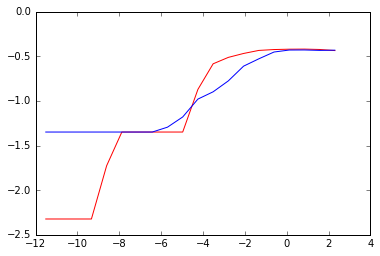

In [81]:
plt.plot(*zip(*np.log(l1error)),c='r')
plt.plot(*zip(*np.log(l2error)),c='b')

In [82]:
l1error.sort(key=lambda tup: tup[1])
l1error[-1]

(2.3357214690901213, 0.6570553712681807)

In [83]:
l2error.sort(key=lambda tup: tup[1])
l2error[-1]

(2.3357214690901213, 0.6506761929063537)

# Trying without stemming --minor reduction in accuracy

In [15]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_tfidf2, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

NameError: name 'train_tfidf2' is not defined

In [16]:
from sklearn.linear_model import LogisticRegression

l1error=[]
l2error=[]
i=0
for c in np.logspace(-2,2,20):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=c, tol=0.01)
    regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.01)
    
    regressionl1.fit(data_train, labels_train)
    regressionl2.fit(data_train, labels_train)
    
    l1error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    
    l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


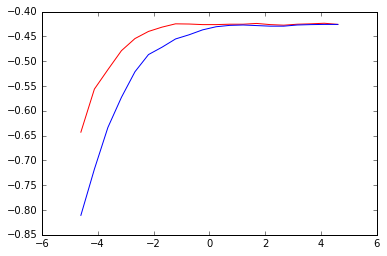

In [17]:
plt.plot(*zip(*np.log(l1error)),c='r')
plt.plot(*zip(*np.log(l2error)),c='b')

In [18]:
l1error.sort(key=lambda tup: tup[1])
l1error[-1]

(61.584821106602604, 0.65475886705792297)

In [19]:
l2error.sort(key=lambda tup: tup[1])
l2error[-1]

(100.0, 0.65322786425108448)

# Try random forest on stemmed data -- takes too long to compute, when tried with 5 trees gives 40% accuracy

In [36]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_tfidf100, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
scores_validation = []
scores_train = []
for i in xrange(25,125,50):
    print(i)
    forest = RandomForestClassifier(n_estimators = i)
    forest = forest.fit(data_train, labels_train)
    
    results_validation = forest.predict(data_validation)
    curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
    
    results_train = forest.predict(data_train)
    curr_score_train = sklearn.metrics.accuracy_score(labels_train, results_train, normalize=True)
    
    scores_validation.append((i,curr_score_valid))
    scores_train.append((i,curr_score_train))

25
75


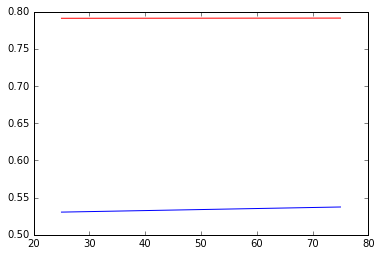

In [40]:
plt.plot(*zip(*scores_train),c='r')
plt.plot(*zip(*scores_validation),c='b')

In [43]:
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(data_train, labels_train)
    
results_validation = forest.predict(data_validation)
curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
curr_score_valid    

0.5404439908139832

# Naive Bayes is at 60% when using Brown corpus as idf

In [243]:
from sklearn.naive_bayes import MultinomialNB

bayesmodel = MultinomialNB()
bayesmodel.fit(data_train, labels_train)

pred = bayesmodel.predict(data_validation)
sklearn.metrics.accuracy_score(labels_validation, pred)

0.60142893595304925

In [244]:
from sklearn.naive_bayes import MultinomialNB

bayesmodel = MultinomialNB()
bayesmodel.fit(data_train_and_validation, labels_train_and_validation)

pred = bayesmodel.predict(data_validation)
sklearn.metrics.accuracy_score(labels_validation, pred)

0.6129114570043378

In [245]:
pred = bayesmodel.predict(data_test)
sklearn.metrics.accuracy_score(labels_test, pred)

0.58796508957280658

In [246]:
pred = bayesmodel.predict(data_train)
sklearn.metrics.accuracy_score(labels_train, pred)

0.60228432873915261

# SVM on Brown corpus with stemming, lemmatization - 65%

In [247]:
from sklearn import svm

svmlinear = svm.LinearSVC(C =0.083021756813197442 )

svmlinear.fit(data_train_and_validation, labels_train_and_validation)

sklearn.metrics.accuracy_score(labels_test, svmlinear.predict(data_test))

0.64400551217271473

In [89]:
error=[]
i=0

for c in np.logspace(-2,-1,100):
    #print("Printing penalty")
    #print(c)
    if i%10==0:
        print(i)
    i=i+1
    svmlinear = svm.LinearSVC(C=c)
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

0
10
20
30
40
50
60
70
80
90


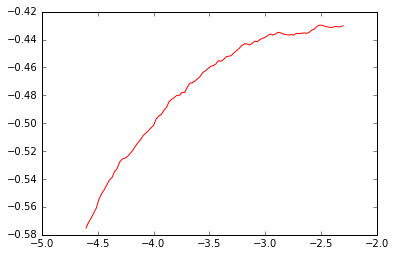

In [90]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])

In [91]:
error[-1]

(0.083021756813197442, 0.6506761929063537)

In [65]:
error=[]
i=0
q
for c in np.logspace(-5,5,10):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    svmlinear = svm.SVC(C=c, kernel='poly')
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

NameError: name 'q' is not defined

In [ ]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])
error[-1]

In [15]:
error=[]
i=0

for c in np.logspace(-5,5,10):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    svmlinear = svm.SVC(C=c, kernel='rbf')
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

0


KeyboardInterrupt: 

In [ ]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])
error[-1]

# Trying out adaboost with logistic regression

In [75]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression



In [76]:
errors = []
for i in np.linspace(100,300,50):

    clf = AdaBoostClassifier(SGDClassifier(),n_estimators = 100, algorithm='SAMME')
    clf.fit(data_train,labels_train)
    acc=sklearn.metrics.accuracy_score(labels_test,clf.predict(data_test))
    
    errors.append((i,acc))
    


KeyboardInterrupt: 

In [ ]:
plt.plot(*zip(*np.log(errors)),c='r')

errors.sort(key = lambda x: x[1])
errors[-1]

# trying an ensemble

In [119]:
model_logistic = regressionl1
model_bayes = bayesmodel
model_svm = svmlinear

In [120]:
import cPickle
# save the classifier
with open('regression.pkl', 'wb') as fid:
    cPickle.dump(model_logistic, fid)    

with open('bayes.pkl', 'wb') as fid:
    cPickle.dump(model_bayes, fid)
    
with open('svm.pkl', 'wb') as fid:
    cPickle.dump(model_svm, fid)

In [237]:

pred_logistic = model_logistic.predict(data_test)


In [248]:
pred_bayes = model_bayes.predict(data_test)
pred_svm= model_svm.predict(data_test)

In [250]:
sklearn.metrics.accuracy_score(labels_test,model_bayes.predict(data_test))

0.58796508957280658

In [251]:
commodity = list(np.unique(pred_logistic))
def conv(arr):
    i=0
    for com in commodity:
        arr[arr==com] = i
        i+=1
    return arr

pred_logistic_c = conv(pred_logistic)
pred_bayes_c = conv(pred_bayes)
pred_svm_c = conv(pred_svm)
    

In [252]:
pred_bayes_c = conv(pred_bayes)

In [253]:
labels_test_c = conv(labels_test)

In [254]:
pred_bayes = pred_bayes.astype(int)
pred_bayes

array([4, 4, 4, ..., 4, 5, 5])

In [255]:
predictions = zip(pred_logistic,pred_bayes,pred_svm)
ensemblepredictionszip = zip(predictions,labels_test)

In [265]:
def ensembleprediction(pred):
    finale = []
    for row in pred:
        predtuple = row[0]
        ans = row[1]
        
        preddict = {}
        for ind in predtuple:
            if ind not in preddict:
                preddict[ind] = 1
            else:
                preddict[ind] = preddict[ind]+1
        
        highestnum = -1
        highestprediction = 3
        
        for k,v in preddict.iteritems():
            if v>highestnum:
                highestnum = v
                highestprediction = k
                
        if highestnum==1:
            highestprediction = predtuple[0]
        
        finale.append(highestprediction)
        #print(preddict,highestprediction)
        
    return finale

In [266]:
ensemble007 = ensembleprediction(ensemblepredictionszip)
sklearn.metrics.accuracy_score(ensemble007,list(labels_test.as_matrix()))

0.65273311897106112

In [258]:
pred_logistic

array([4, 4, 1, ..., 4, 0, 1], dtype=object)

In [259]:
sklearn.metrics.accuracy_score(list(labels_test.as_matrix()),list(pred_logistic))

0.65870463941203494

In [260]:
print(sklearn.metrics.accuracy_score(labels_test_c.tolist(),pred_logistic_c.tolist()))

0.658704639412
